In [110]:
# import autograd functionalities
import autograd.numpy as np
from autograd import grad as compute_grad   

# import plotting library and other necessities
import matplotlib.pyplot as plt
from matplotlib import gridspec

# import general libraries
import copy
from datetime import datetime 

##### import custom libs #####
import normalizers
from convnet import superlearn_setup as setup_multi

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

import sys
sys.path.append('../../')

from timeit import default_timer as timer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load in mnist image data

In [111]:
# load data
datapath = 'datasets/mnist/MNIST_train_data.csv'
data = np.loadtxt(datapath,delimiter = ',')
print(np.shape(data))

# import data and reshape appropriately
x = data[:,:-1]
print(np.shape(x))
y = data[:,-1:]  # subtract 1 to bring range of labels to 0 - 9
print(np.shape(y))

(60000, 785)
(60000, 784)
(60000, 1)


In [112]:
x = x.T# N * P
y = (y-1).T# M * P # subtract 1 to bring range of labels to 0 - 9

In [113]:
P = np.size(y) 
# random subset of full dataset
inds = np.random.permutation(P)[:10000]
x_samples = x[:,inds]
y_samples = y[:,inds]

In [114]:
x_samples = np.concatenate((x_samples,x_samples,x_samples),axis=0)
print(np.shape(x_samples))

(2352, 10000)


# contrast normalize images

In [80]:
normalizer,inverse_normalizer = normalizers.standard(x_samples)
x_samples = normalizer(x_samples)

# Build and tune a multilayer convnet

Below is an example using the updated API - in particular below shows an example of a convnet with one convolution layers, one pooling layer, and one activation layer - then a fully connected network on top of it with a single hidden layer. 

The CNN layer is one layer, kernel number is 8, kernel size is 3 by 3.

Note in terms of usage, there are now 5 steps to setting up a convnet using our API

1) **Setting up the experiment via** `Setup` - here we load in the data, normalize it using a standard or ZCA-sphereing.


2)  **Constructing the convnet portion of the network ** - this involves adding `conv`, `pool`, and `activation` layers.  Note when adding a conv layer via `add_conv_layer` you can turn on / off padding by setting `pad = True` or `pad = False` (note: the default is `pad = True`), control the convolution stride via the `stride` variable, `num_kernels` and `kernel_size` directly.  You can likewise control the pooling stride via the `stride` variable when adding a pooling layer via `add_pool_layer`.


3)  **Constructing the fully connected portion of the network** - You can set any number perceptron in each fully connected layers.


4)  **Choosing a cost function** - Select cost function for different problem you are solving: Regression, two-classification or multiclassification


5)  **Running an optimization** - Set the hyperparameters, notice: the each iteration means running the whole train dataset once.

6) **Saving the training result** - You can save the tuned model and reload it in next time.

7) **Make prediction based on a tuned model** - Load the tuned weights, and make prediction.

iteration 1 done in 34.7 secs, train cost = 0.6511, train accuracy = 0.8176, val cost = 0.6865, val accuracy = 0.8087
iteration 2 done in 33.2 secs, train cost = 0.2904, train accuracy = 0.9124, val cost = 0.3766, val accuracy = 0.893
iteration 3 done in 32.7 secs, train cost = 0.1908, train accuracy = 0.944, val cost = 0.3049, val accuracy = 0.9153
iteration 4 done in 33.2 secs, train cost = 0.1457, train accuracy = 0.9584, val cost = 0.2869, val accuracy = 0.9193
iteration 5 done in 33.2 secs, train cost = 0.1157, train accuracy = 0.9657, val cost = 0.286, val accuracy = 0.9197
finished all 5 iterations


<IPython.core.display.Javascript object>


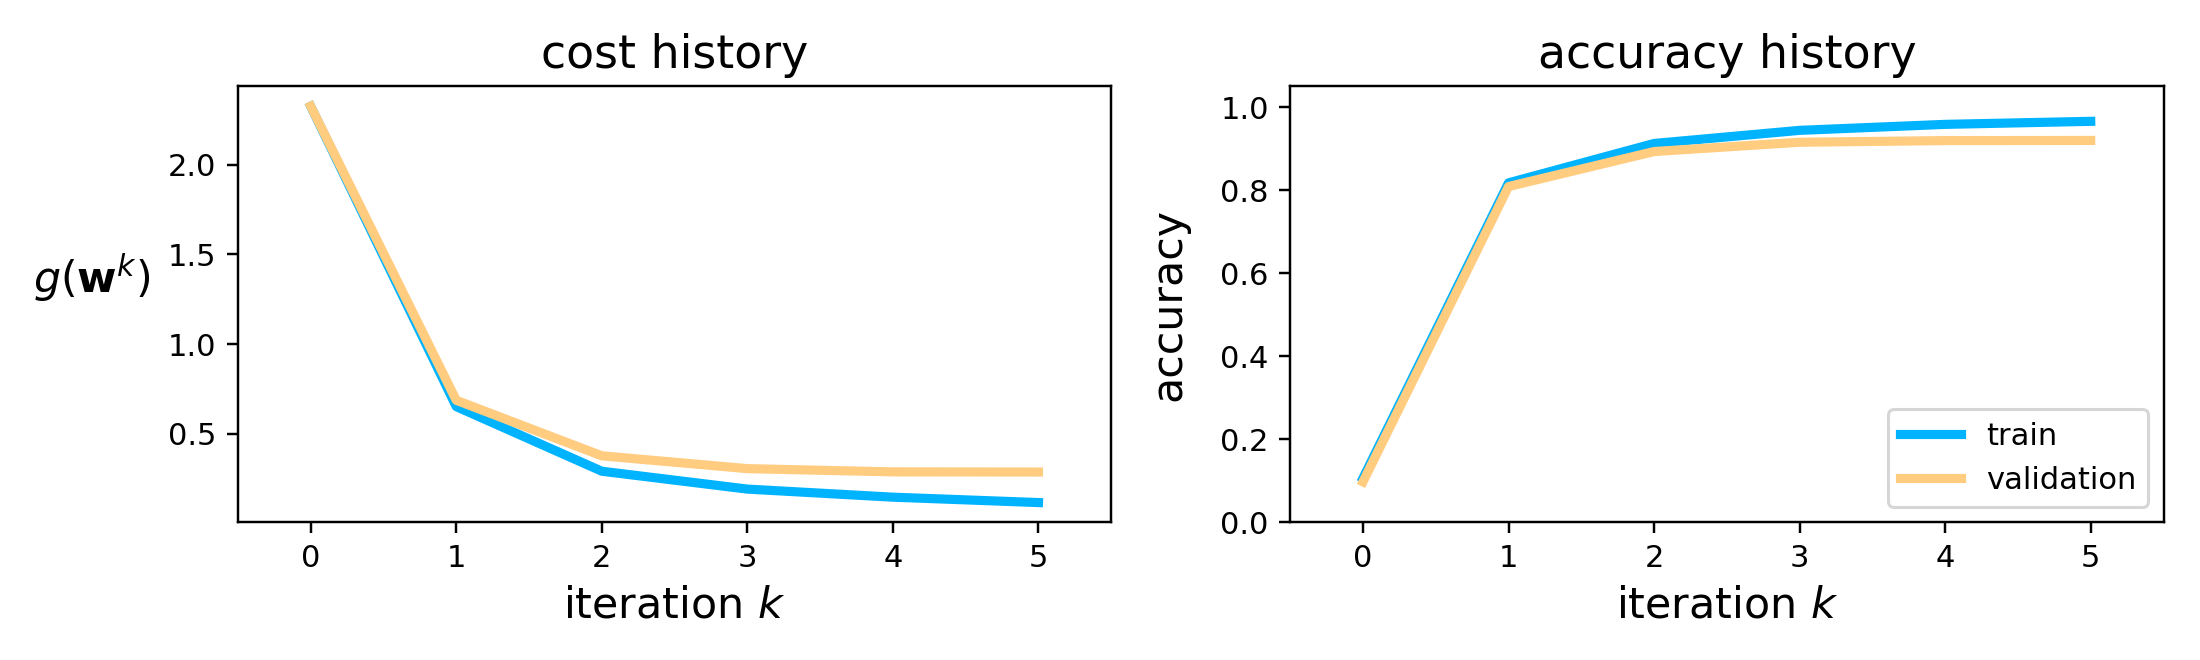

In [115]:
# can not change kernel_size, 
# pad can not be True after first layer.

## This code cell will not be shown in the HTML version of this notebook
# import the library
minist_test = setup_multi.Setup(x_samples,y_samples,normalizer = 'ZCA_sphere')

### make conv portion of network ###
# add first conv layer --> note pad = True here, and the kernel_size = 5 instead of 3
num_kernels = 8; 
minist_test.add_conv_layer(num_kernels,kernel_size = 3, stride = 1, pad = True)

# add pool layer
minist_test.add_pool_layer(window_size = 3, stride = 2)

# add activation layer
minist_test.add_activation_layer(activation = 'relu')

# add fully connected layer
layer_sizes = [100]
minist_test.add_full_layers(name = 'multilayer_perceptron',layer_sizes = layer_sizes,super_type = 'classification',activation = 'maxout')

### choose cost function and run ###
minist_test.choose_cost(name = 'multiclass_softmax')

# split into training and validation sets
minist_test.make_train_val_split(train_portion = 0.7)

# run optimization
minist_test.fit(max_its = 5,alpha_choice = 10**(0),batch_size = 500,verbose = True)

# show cost function history
minist_test.show_histories()

In [116]:
minist_test.save_best_weights('./saved_model/minist_test_best_weights')

In [117]:
minist_test.load_pretrained_weights('./saved_model/minist_test_best_weights.npy')

## 1.Example predictions on Test set

<IPython.core.display.Javascript object>


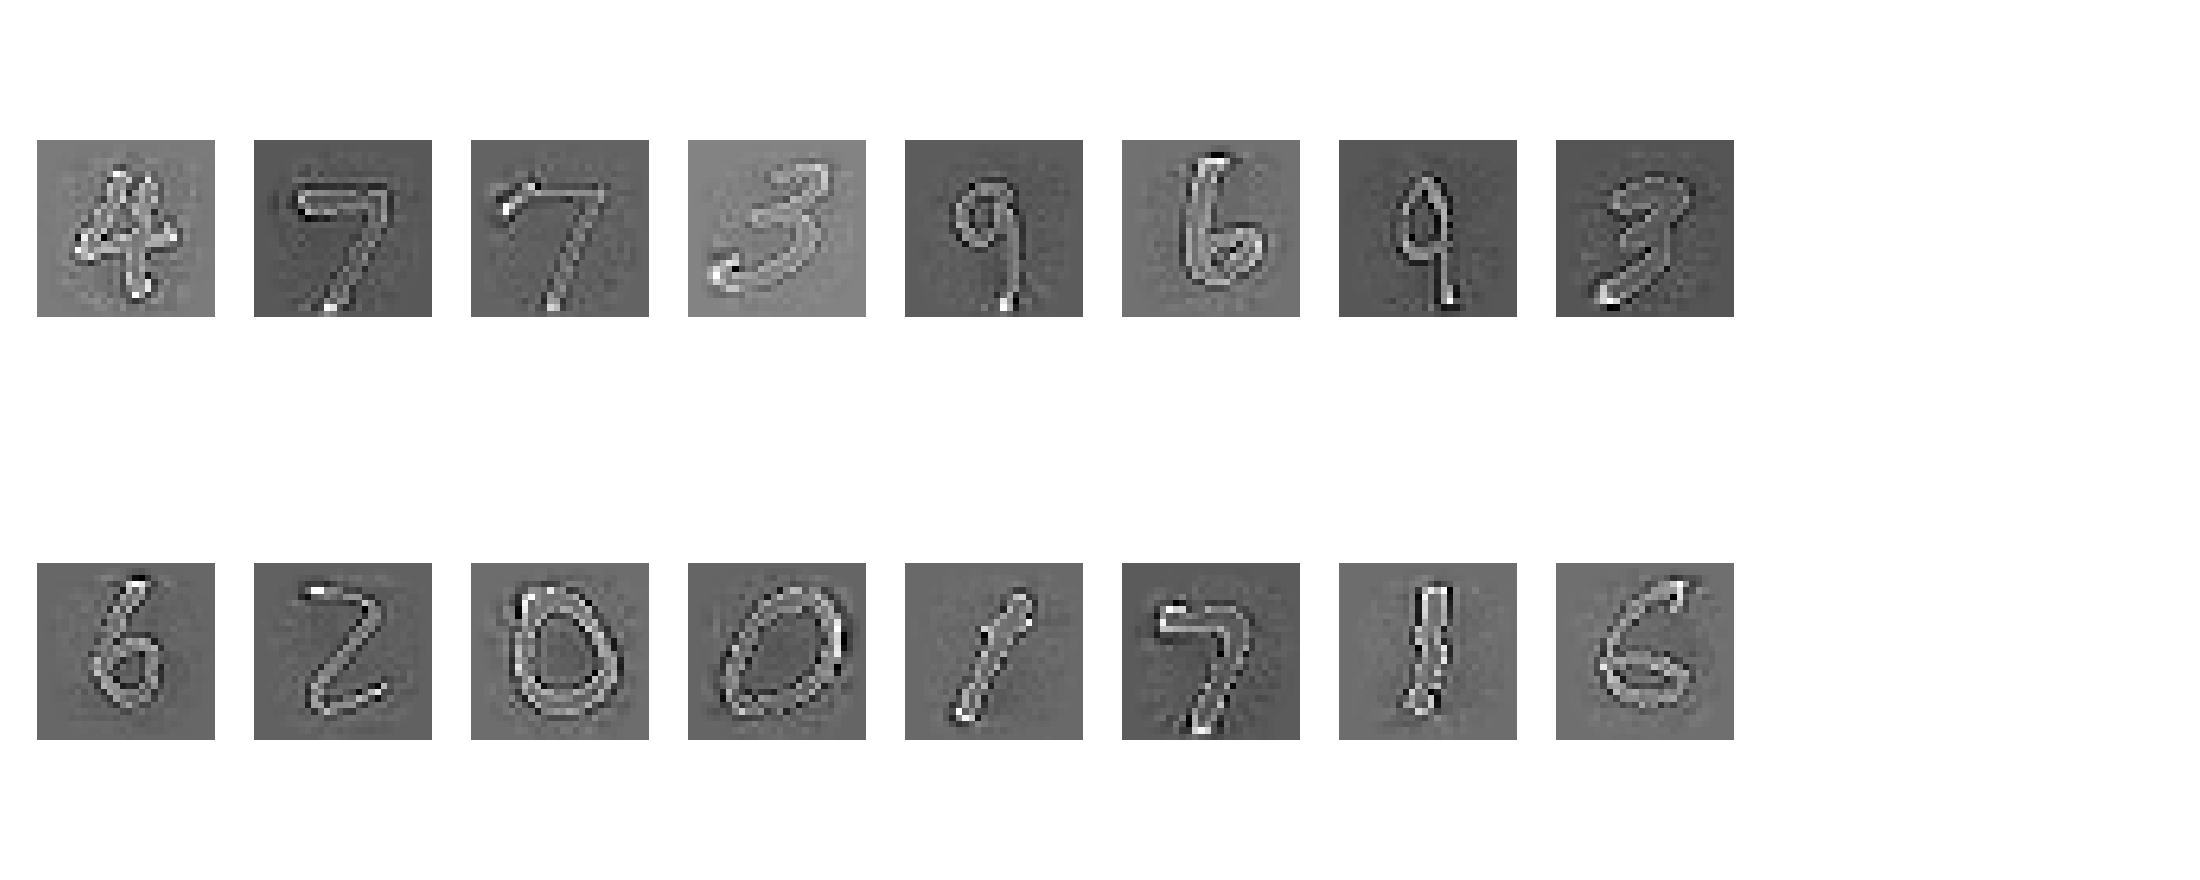

In [118]:
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10,4))
gs=GridSpec(2,10)

for i in range(0,16):
    fig.add_subplot(gs[(i)%8 + int((i)/8)*10])
    plt.imshow(np.reshape(minist_test.x_val[i,0,:,:],(28,28),1),cmap='gray')
    
    plt.xticks([]), plt.yticks([])
    plt.axis('off') 
    
plt.show()

In [120]:
predict_test_labels = minist_test.predict_test_data(minist_test.x_val[:16])
print(predict_test_labels)

[4 7 7 3 9 6 9 3 6 2 0 0 1 7 1 6]


## 2.Predict on new data

<IPython.core.display.Javascript object>


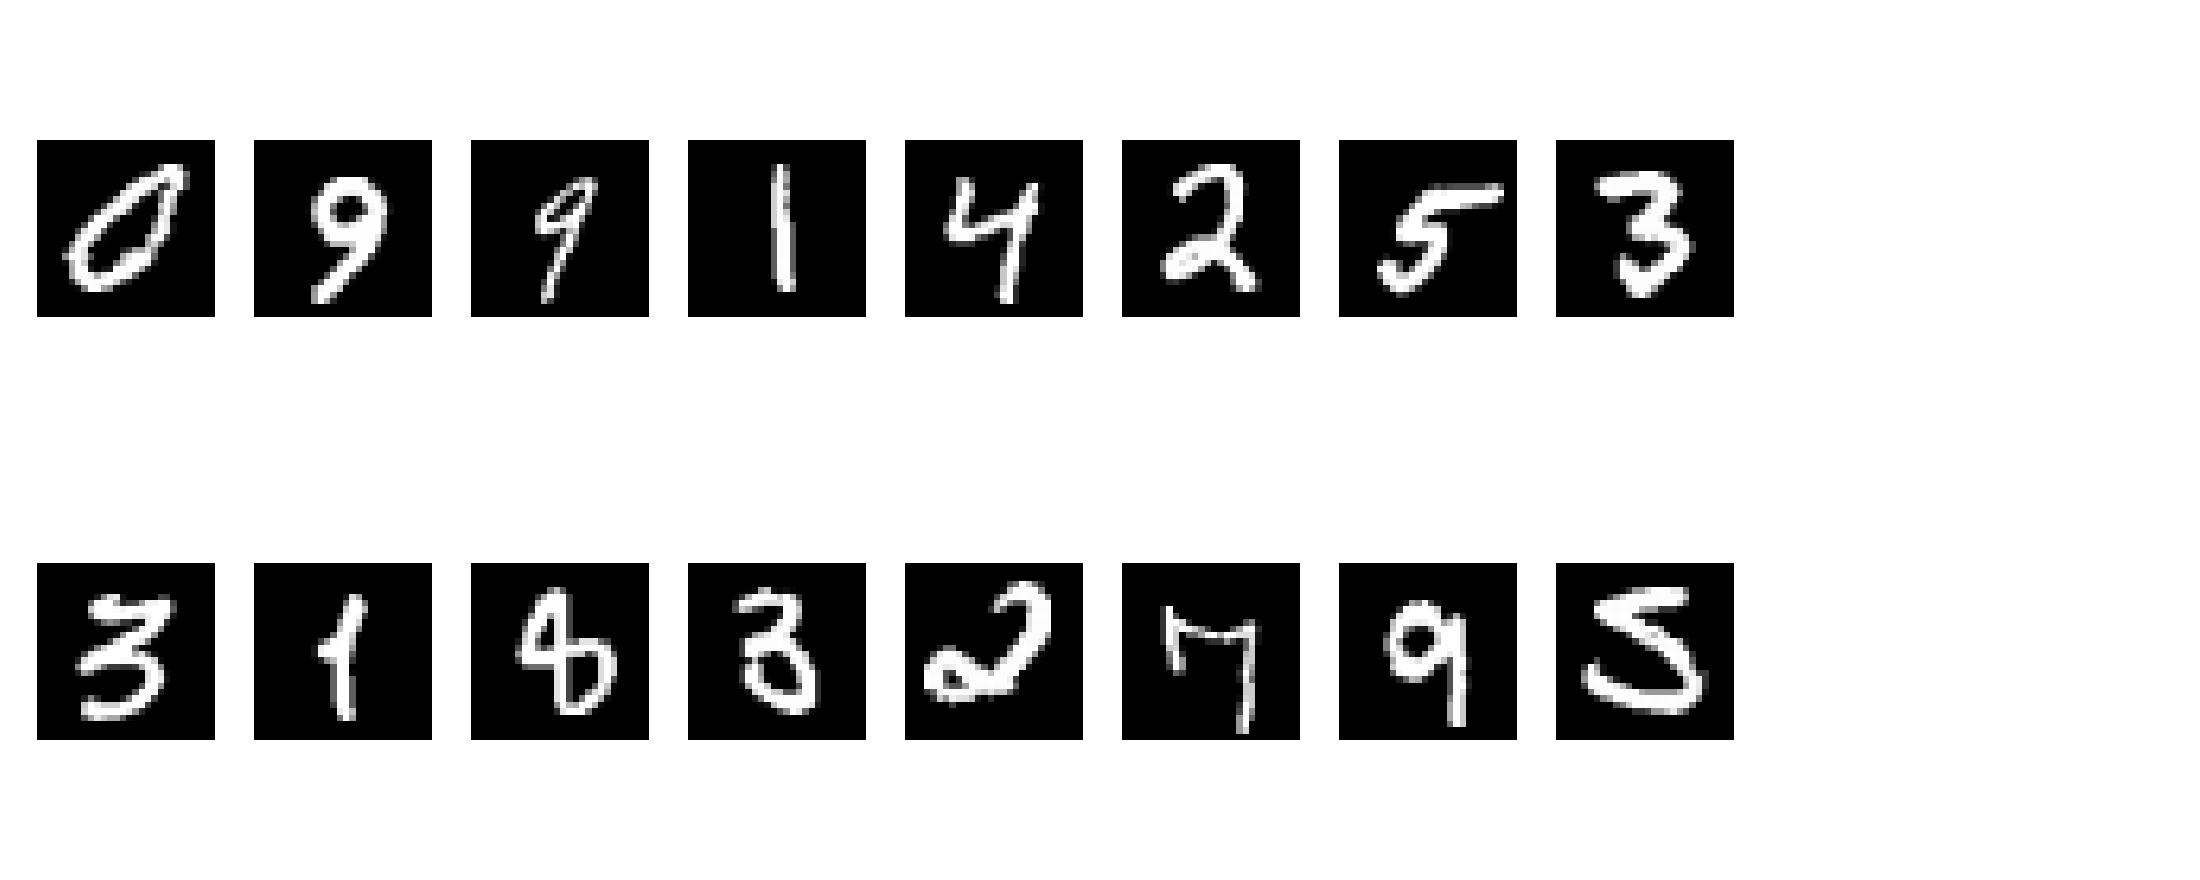

In [121]:
fig = plt.figure(figsize=(10,4))
gs=GridSpec(2,10)

for i in range(0,16):
    fig.add_subplot(gs[(i)%8 + int((i)/8)*10])
    plt.imshow(np.reshape(x_samples[:784,i],(28,28),1),cmap='gray')
    
    plt.xticks([]), plt.yticks([])
    plt.axis('off') 
    
plt.show()

In [122]:
predict_new_labels = minist_test.predict_new_data(x_samples[:,:16])

In [123]:
print(predict_new_labels)

[0 9 9 1 4 2 5 3 3 1 6 6 2 8 9 5]
